In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from nltk.translate.bleu_score import corpus_bleu
import time
import re

nltk.download('punkt') 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/loki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
df=pd.read_csv("translations.csv")
df.head(10)

,English,Hindi,Original
0,No staged files selected.,नहीं फ़ाइल चयनित.,नहीं फ़ाइल चयनित.
1,SMTP Server,एस एम टी पी सर्वर,एस एम टी पी सर्वर
2,Yes,हाँ,हाँ
3,Group,समूह,समूह
4,Stash,स्थिति,स्थिति
5,Go to symbol definition,जाएँ को परिभाषा,जाएँ को परिभाषा
6,Please specify group name,कृपया समूह नाम,कृपया समूह नाम
7,"Search for ""% s"" reached top and was continued...",ढूंढें के लिए से. उपर और एट नीचे नहीं नया पाया.,ढूंढें के लिए से. उपर और एट नीचे नहीं नया पाया.
8,_ Selection,चयन (_ S),चयन (_ S)
9,Keywords:,बीजशब्दः,बीजशब्दः


In [16]:
eng=df['English'].astype(str)
orig=df['Original'].astype(str)
pred=df['Hindi'].astype(str)

In [17]:
eng.head(10)

0                            No staged files selected.
1                                          SMTP Server
2                                                  Yes
3                                                Group
4                                                Stash
5                              Go to symbol definition
6                            Please specify group name
7    Search for "% s" reached top and was continued...
8                                          _ Selection
9                                            Keywords:
Name: English, dtype: object

In [18]:
orig.head(10)

0                                  नहीं फ़ाइल चयनित. 
1                                   एस एम टी पी सर्वर
2                                                 हाँ
3                                                समूह
4                                              स्थिति
5                                     जाएँ को परिभाषा
6                                      कृपया समूह नाम
7    ढूंढें के लिए से. उपर और एट नीचे नहीं नया पाया. 
8                                          चयन (_ S) 
9                                            बीजशब्दः
Name: Original, dtype: object

In [19]:
pred.head(10)

0                                  नहीं फ़ाइल चयनित.
1                                  एस एम टी पी सर्वर
2                                                हाँ
3                                               समूह
4                                             स्थिति
5                                    जाएँ को परिभाषा
6                                     कृपया समूह नाम
7    ढूंढें के लिए से. उपर और एट नीचे नहीं नया पाया.
8                                          चयन (_ S)
9                                           बीजशब्दः
Name: Hindi, dtype: object

In [20]:
Jaccard_sim=[]
sim_count=[0]*10
ambiguous_eng=[]
ambiguous_orig=[]
ambiguous_pred=[]
best=[]

Jaccard Similarity

In [21]:
for i in range(len(df)):
    words_orig=set(orig[i].lower().split())
    words_pred=set(pred[i].lower().split())
    intersection=words_orig.intersection(words_pred)
    union=words_orig.union(words_pred)
    sim=float(len(intersection)/len(union))
    Jaccard_sim.append(sim)
    index=int(sim*10)
    if index==10 or index==9:
        best.append(eng[i])
        index=9
    if index==0:
        ambiguous_eng.append(eng[i])
        ambiguous_orig.append(orig[i])
        ambiguous_pred.append(pred[i])
    sim_count[index]+=1
print(sim_count)

[211, 32, 37, 43, 13, 38, 26, 15, 6, 2579]


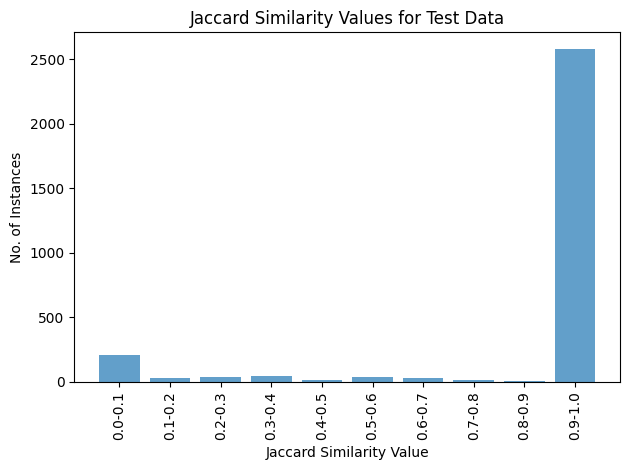

In [22]:
x_labels = [f"{i/10:.1f}-{(i+1)/10:.1f}" for i in range(10)]
x_positions = range(len(sim_count))
plt.bar(x_positions, sim_count, align='center', alpha=0.7)
plt.xticks(x_positions, x_labels, rotation='vertical')

plt.xlabel('Jaccard Similarity Value')
plt.ylabel('No. of Instances')
plt.title('Jaccard Similarity Values for Test Data')
plt.tight_layout()
plt.show()

In [23]:
print(ambiguous_eng)
print(ambiguous_orig)
print(ambiguous_pred)

['[Invalid]', 'Start:% d', 'FAQ', '/ View / Sorting / Sort Descending', 'Say goodbye to the debugger', '_ Name:', 'Choose destination folder', 'Anjuta help search', '_ View Source', 'Version', '_ Sample action', 'Loading project:% s', 'Search', 'Generate Patch Series', '_ Header Font:', 'Search Variable', 'Session', 'Address', 'Search Help:', 'Browse…', 'Copy the selection', '_ View', 'Type:', '% s on reserve', 'Editor zoom operations', 'Man Documentation', 'FAQ', 'Four Foundations', 'Pass:', 'Unloaded', '_ Save', 'From:', 'Django Project information', 'Item', 'Hostname:', 'Five Foundations', 'Attachment', 'A shared or a static library project', 'Brasero is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.', 'Xlib dock', '_ Import Tree', 'Select header file', 'Show kernel signals', 'Reply to _ All...', '_ Update', '_ Remo

Cosine Similarity

In [24]:
Cosine_sim=[]
sim_count=[0]*10

In [25]:
for i in range(len(df)):
    token_pred=nltk.word_tokenize(pred[i])
    token_orig=nltk.word_tokenize(orig[i])
    pre1=' '.join(token_pred)
    pre2=' '.join(token_orig)
    vectorizer=CountVectorizer(tokenizer=lambda text: text.split(),token_pattern='')
    vectorizer_text=vectorizer.fit_transform([pre1,pre2])
    sim=cosine_similarity(vectorizer_text)[0][1]
    Cosine_sim.append(sim)
    index=int(sim*10)
    if index==10 or index==9:
        index=9
    sim_count[index]+=1
print(sim_count)

/home/loki/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[192, 12, 22, 16, 44, 21, 25, 46, 25, 2597]


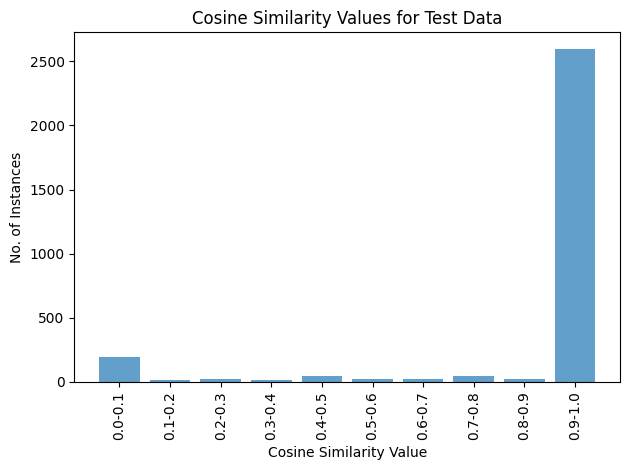

In [26]:
x_labels = [f"{i/10:.1f}-{(i+1)/10:.1f}" for i in range(10)]
x_positions = range(len(sim_count))
plt.bar(x_positions, sim_count, align='center', alpha=0.7)
plt.xticks(x_positions, x_labels, rotation='vertical')

plt.xlabel('Cosine Similarity Value')
plt.ylabel('No. of Instances')
plt.title('Cosine Similarity Values for Test Data')
plt.tight_layout()
plt.show()

BLUE Score

In [27]:
references = []
hypotheses = []

for sentence in df["Hindi"]:
    hypotheses.append(str(sentence))

for sentence in df["Original"]:
    references.append([str(sentence)])

# Calculate BLEU score
bleu_score = corpus_bleu(references, hypotheses)

print(f'BLEU Score: {bleu_score * 100:.2f}%')

BLEU Score: 87.15%
